# ImageCLEF Medical Caption Task 2024



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
import tensorflow as tf
import seaborn as sns
import matplotlib.style as style
from tensorflow.keras import datasets, layers, models

2024-04-26 09:13:10.432098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 09:13:12.529329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 09:13:12.529461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 09:13:12.740517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 09:13:13.247194: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#!echo "Y" |!pip uninstall tensorflow
#!pip uninstall seaborn
#!pip install tensorflow
#!pip install seaborn
!pip show tensorflow

Name: tensorflow
Version: 2.15.0.post1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/ex5/anaconda3/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
## Data Exploration

#### We will start by loading the CSV files in order to explore the data a bit.

In [2]:
data_filename = 'cui_mapping.csv'
string_concepts = pd.read_csv(data_filename,header = None)

In [3]:
string_concepts.columns = ['CUIs','Canonical']

In [4]:
string_concepts['Canonical']= string_concepts['Canonical'].str.split(',')

In [5]:
string_concepts.shape

(1934, 2)

#### We have $5528$ types of UMLS Concepts

In [6]:
string_concepts.head()

,CUIs,Canonical
0,C0016522,"[Foramen Ovale, Patent]"
1,C0457846,[Cervical segment of spinal cord]
2,C0578537,[Cavitation of lung]
3,C0179751,[Epidural catheter]
4,C3489393,[Hiatal Hernia]


In [7]:
data_filename = 'train_concepts.csv'
train_concepts = pd.read_csv(data_filename)

In [8]:
train_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2024_train_000001,C0040405
1,ImageCLEFmedical_Caption_2024_train_000002,C0041618
2,ImageCLEFmedical_Caption_2024_train_000003,C0040405;C0817096;C0205271
3,ImageCLEFmedical_Caption_2024_train_000004,C0002978;C0036033;C1266909;C0225317
4,ImageCLEFmedical_Caption_2024_train_000005,C0040405;C0817096;C0497156


We are going to use a **copy** of the dataframe in order to calculate some staticstics

In [9]:
copy = train_concepts.copy()

* We will investigate which concept is more frequent on the images

In [10]:
copy['CUIs']= copy['CUIs'].str.split(';')

In [11]:
x = sum(copy.CUIs, [])
from collections import Counter
c = Counter(x)
results =c.most_common(10)

In [12]:
most_frequent = pd.DataFrame(results)

In [13]:
most_frequent.columns = ['CUIs','Images']
umls_terms = pd.merge(most_frequent, string_concepts,on = 
                     'CUIs', how = 'left') 

In [14]:
umls_terms

,CUIs,Images,Canonical
0,C0040405,24227,[X-Ray Computed Tomography]
1,C1306645,19363,[Plain x-ray]
2,C0024485,11296,[Magnetic Resonance Imaging]
3,C0041618,9870,[Ultrasonography]
4,C0817096,8912,[Chest]
5,C0002978,4387,[angiogram]
6,C0037303,3737,[Bone structure of cranium]
7,C0000726,3726,[Abdomen]
8,C0030797,3154,[Pelvis]
9,C0023216,2791,[Lower Extremity]


* We notice that the most common CUIs are standard scanning procedures

* The next step would be to find out how many tags are there in each image.

In [15]:
copy['Number of Tags'] = copy.ID.str.len()

In [16]:
copy.head()

,ID,CUIs,Number of Tags
0,ImageCLEFmedical_Caption_2024_train_000001,[C0040405],42
1,ImageCLEFmedical_Caption_2024_train_000002,[C0041618],42
2,ImageCLEFmedical_Caption_2024_train_000003,"[C0040405, C0817096, C0205271]",42
3,ImageCLEFmedical_Caption_2024_train_000004,"[C0002978, C0036033, C1266909, C0225317]",42
4,ImageCLEFmedical_Caption_2024_train_000005,"[C0040405, C0817096, C0497156]",42


In [17]:
data_filename = 'valid_concepts.csv'
val_concepts = pd.read_csv(data_filename)

In [18]:
val_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2024_valid_000001,C0040405;C0856747
1,ImageCLEFmedical_Caption_2024_valid_000002,C0040405;C0040053
2,ImageCLEFmedical_Caption_2024_valid_000003,C0002978
3,ImageCLEFmedical_Caption_2024_valid_000004,C0002978;C0034052;C0521377
4,ImageCLEFmedical_Caption_2024_valid_000005,C0040405


#### Let's now continue by ploting some images 

In [19]:
from PIL import Image

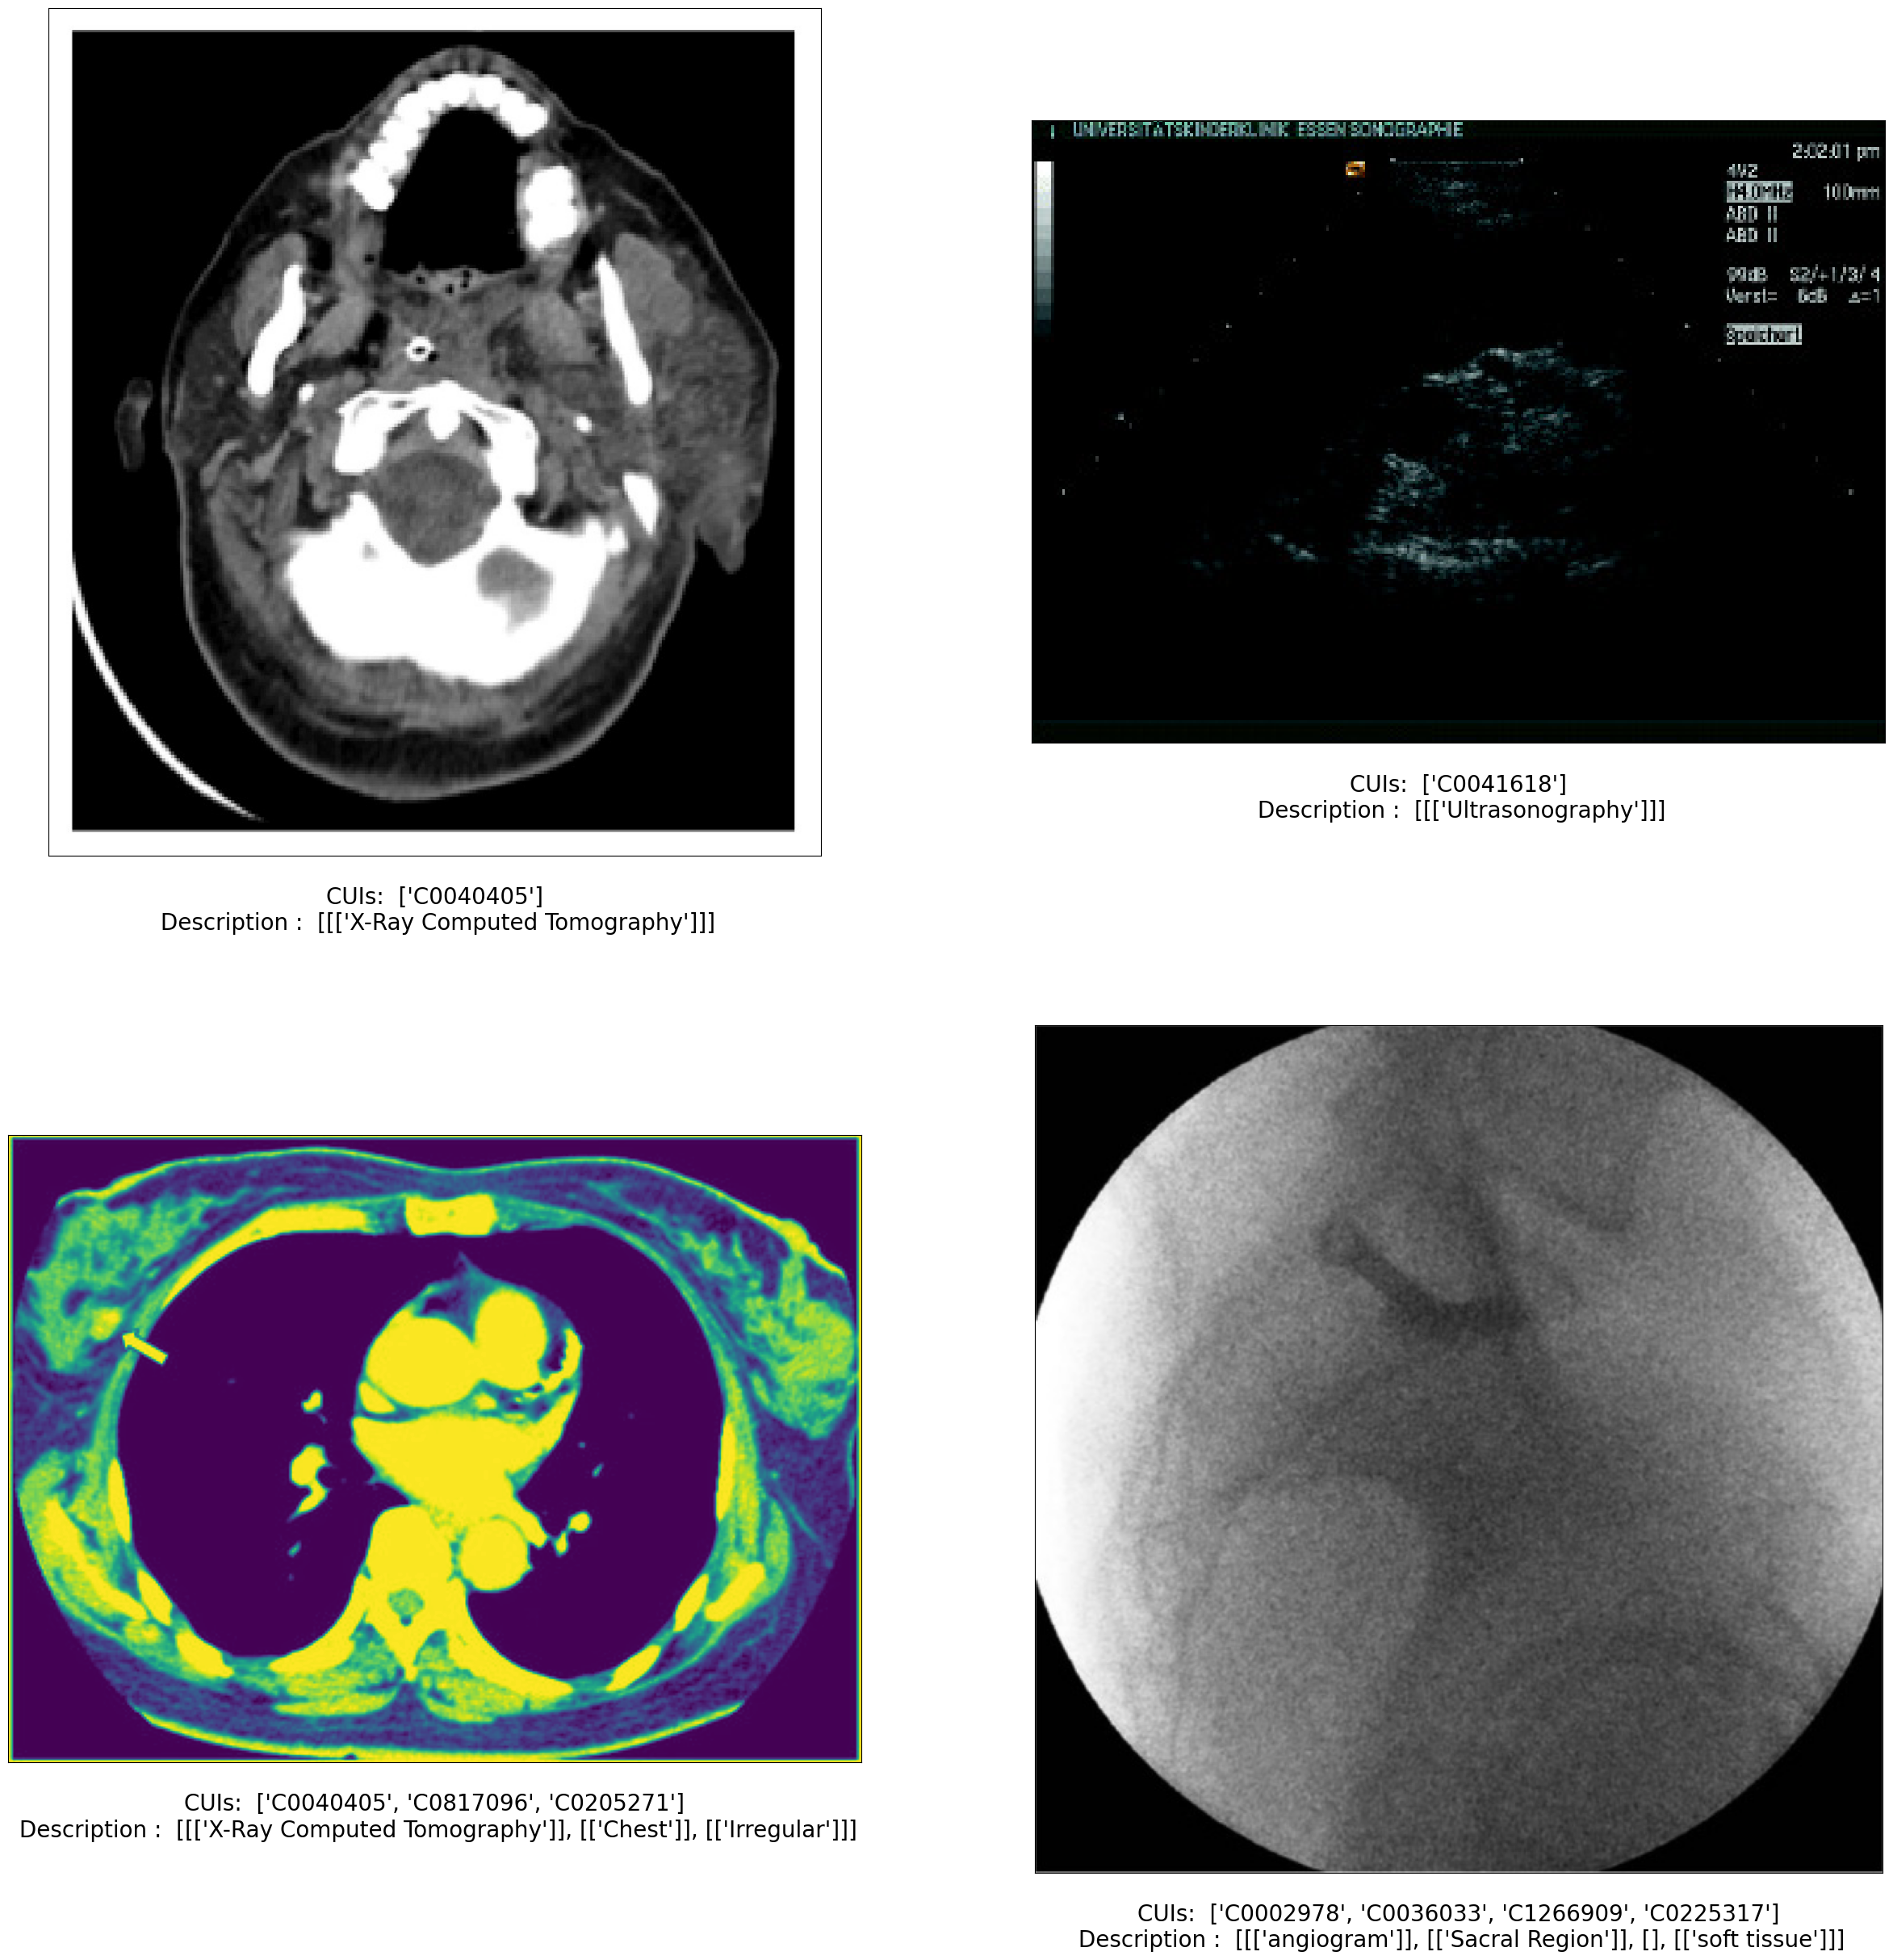

In [20]:
plt.figure(figsize=(30,30))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = Image.open('/home/ex5/Desktop/ImageCLEF/dataset/images/train/'+copy.ID[i]+'.jpg')
    plt.imshow(img)
    desc = []
    for item in copy.CUIs[i]:
        temp = string_concepts.loc[string_concepts['CUIs'] == item]
        desc.append(temp['Canonical'].tolist())
    plt.xlabel('\n'+'CUIs:  '+ str(copy.CUIs[i])+ '\n Description :  '+ str(desc) ,fontsize = 20)

## Data Preprocessing

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### We need to transform the labels from the ';' delimeter to a list of strings

In [20]:
train_concepts['CUIs']= train_concepts['CUIs'].str.split(';')

#### We will also add the extension '.jpg' in order for the generator to be able to identify the files

In [21]:
train_concepts['ID'] = train_concepts['ID'] +'.jpg'

In [22]:
train_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2024_train_000001.jpg,[C0040405]
1,ImageCLEFmedical_Caption_2024_train_000002.jpg,[C0041618]
2,ImageCLEFmedical_Caption_2024_train_000003.jpg,"[C0040405, C0817096, C0205271]"
3,ImageCLEFmedical_Caption_2024_train_000004.jpg,"[C0002978, C0036033, C1266909, C0225317]"
4,ImageCLEFmedical_Caption_2024_train_000005.jpg,"[C0040405, C0817096, C0497156]"


In [23]:
val_concepts['CUIs']= val_concepts['CUIs'].str.split(';')

In [24]:
val_concepts['ID']= val_concepts['ID']+'.jpg'

In [25]:
val_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2024_valid_000001.jpg,"[C0040405, C0856747]"
1,ImageCLEFmedical_Caption_2024_valid_000002.jpg,"[C0040405, C0040053]"
2,ImageCLEFmedical_Caption_2024_valid_000003.jpg,[C0002978]
3,ImageCLEFmedical_Caption_2024_valid_000004.jpg,"[C0002978, C0034052, C0521377]"
4,ImageCLEFmedical_Caption_2024_valid_000005.jpg,[C0040405]


## Data Generators

#### We will define the path for the images directories beforehand

In [28]:
import os

In [29]:
train_dir = '/home/ex5/Desktop/ImageCLEF/dataset/images/train'
validation_dir = '/home/ex5/Desktop/ImageCLEF/dataset/images/valid'
test_dir = '/home/ex5/Desktop/ImageCLEF/dataset/images/test'

In [30]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))
num_test = len(os.listdir(test_dir))
total_train = num_tr
total_val = num_val

In [31]:
print('total training images:', num_tr)
print('total validation images:', num_val)
print('total testing images:', num_test)

total training images: 69999
total validation images: 9972
total testing images: 109


* We will get 128 images per batch.

* We will train for 2 epochs.

* We will size the images to 224x224 pixels in order to also be compliable with Pre-trained models.

In [42]:
batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

* We will read the batches using `ImageDataGenerator`, offerred by keras.

* This will create a Python generator that, when we call it, will return the next batch.

* While doing so, it will scale the pixel values from 0 to 1.

#### We will also augment the train images using random horizontal flip

In [31]:
train_image_generator = ImageDataGenerator(rescale=1./255,horizontal_flip = True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator=ImageDataGenerator(rescale=1./255.)# Generator for our testing data


In [32]:
dev_image_generator = ImageDataGenerator(rescale = 1./255.)#Generator for the valiation evaluation

#### We are going to create a column containg the index in order to apply multilabel encoding in the steps ahead 

In [39]:
train_concepts['index'] = train_concepts.index

In [34]:
val_concepts['index'] = val_concepts.index

#### We will combine the two dataframes in order for the classifier to be trained wth all classes names

In [35]:
full = pd.concat([train_concepts, val_concepts], sort=False)

In [36]:
full.shape

(80080, 3)

#### We will create the training and validation generators using the data from the dataframes and the corresponding images.

In [45]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=full.iloc[0:69999],#we only get the training images
                                                           directory = train_dir,
                                                           x_col="ID",
                                                           y_col="index",
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'other'
                                                          )

Found 69999 validated image filenames.


In [48]:
x, _ = next(train_data_gen)
print(x.shape)  # This should print (batch_size, 224, 224, 3)

(128, 224, 224, 3)


#### We are going to transform the labels to arrays using Scikit Learn MultiLabel Binarizer

In [49]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(full['CUIs'].values)

MultiLabelBinarizer()

In [50]:
N_LABELS = len(mlb.classes_)

In [51]:
list(mlb.classes_)

['C0000726',
 'C0000833',
 'C0000846',
 'C0000962',
 'C0001074',
 'C0001162',
 'C0001168',
 'C0001208',
 'C0001209',
 'C0001304',
 'C0001339',
 'C0001428',
 'C0001430',
 'C0001511',
 'C0001516',
 'C0001527',
 'C0001624',
 'C0001625',
 'C0001863',
 'C0002382',
 'C0002390',
 'C0002448',
 'C0002638',
 'C0002708',
 'C0002895',
 'C0002940',
 'C0002949',
 'C0002978',
 'C0003087',
 'C0003090',
 'C0003151',
 'C0003165',
 'C0003461',
 'C0003483',
 'C0003484',
 'C0003486',
 'C0003489',
 'C0003492',
 'C0003501',
 'C0003504',
 'C0003507',
 'C0003516',
 'C0003615',
 'C0003617',
 'C0003838',
 'C0003842',
 'C0003855',
 'C0003864',
 'C0003943',
 'C0003956',
 'C0003962',
 'C0003964',
 'C0004030',
 'C0004144',
 'C0004153',
 'C0004170',
 'C0004454',
 'C0004455',
 'C0004456',
 'C0004457',
 'C0004526',
 'C0004781',
 'C0004811',
 'C0005400',
 'C0005401',
 'C0005423',
 'C0005558',
 'C0005615',
 'C0005682',
 'C0005683',
 'C0005695',
 'C0005778',
 'C0005847',
 'C0005937',
 'C0005971',
 'C0005974',
 'C0006087',

* We note that **312** of the total of 5528 terms do not exist in the training set images.

In [52]:
N_LABELS

1944

#### We will use this helper function to transform the binarizer to each set

In [53]:
def multilabel_flow_from_dataframe(data_generator, mlb,df):
    for x, y in data_generator:
        indices = y.astype(int).tolist()
        y_multi = mlb.transform(
            df.iloc[indices]['CUIs'].values.tolist()
        )
        yield x, y_multi

In [54]:
multilabel_generator_train = multilabel_flow_from_dataframe(
    train_data_gen, mlb,train_concepts
)

* We are doing the same job for the validation images

In [55]:
val_data_gen = validation_image_generator.flow_from_dataframe(dataframe = full.iloc[70108:80090],
                                                             directory=validation_dir,
                                                             x_col = "ID",
                                                             y_col = "index",
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='other')

Found 9972 validated image filenames.


In [56]:
multilabel_generator_val = multilabel_flow_from_dataframe(
    val_data_gen,mlb,val_concepts
)

* For the test images we must use **None** as class_mode

In [57]:
test_data_gen = test_image_generator.flow_from_dataframe    (
                                                            dataframe=full,
                                                             directory='/home/ex5/Desktop/ImageCLEF/dataset/images/test/',
                                                            x_col='ID',
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode = None
)
print(batch_size)
print(IMG_HEIGHT, IMG_WIDTH)
print(test_dir)

Found 109 validated image filenames.
128
224 224
/home/ex5/Desktop/ImageCLEF/dataset/images/test


/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 79971 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(


* Last, we create a generator in order to use it for the validation images evaluation

In [50]:
dev_data_gen = dev_image_generator.flow_from_dataframe    (
                                                            dataframe=full,
                                                             directory=validation_dir,
                                                            x_col='ID',
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode = None
)

Found 9972 validated image filenames.


/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 70108 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(


## Baseline Classifier

#### We will use Scikit Learn Dummy Classifier with stratified strategy in order to predict tags based on the current set;s class ditribution.

In [51]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

* We will compress the images to $(32,32)$ due to memory constraints

In [52]:
val_image = []
for i in tqdm(range(val_concepts.shape[0])):
    img = image.load_img('/home/ex5/Desktop/ImageCLEF/dataset/images/valid/'+val_concepts['ID'][i], target_size=(32,32,3),grayscale = False)
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
X1 = np.array(val_image)

100%|██████████████████████████████████████| 9972/9972 [01:26<00:00, 115.53it/s]


In [53]:
from sklearn.preprocessing import MultiLabelBinarizer
ml_val = MultiLabelBinarizer()
y1 = ml_val.fit_transform(val_concepts['CUIs'].values)

In [82]:
mlb_dummy = ml_val.fit((val_concepts['CUIs'].values))

In [83]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X1,y1)

DummyClassifier(strategy='stratified')

In [57]:
dummy_predictions = dummy_clf.predict(X1)

* Let's now create a file in order for the results to be passed to the competition's evaluation function.

In [58]:
labels = []
for i in range(dummy_predictions.shape[0]):
    temp = np.where(dummy_predictions[i] > 0)[0]
    label = []
    for value in temp :
        label.append(mlb_dummy.classes_[value])
    labels.append(label)  
files = pd.DataFrame([])
files = pd.DataFrame(os.listdir("/home/ex5/Desktop/ImageCLEF/dataset/images/valid/"), columns=['image'])
files.columns = ['ID']
files = files.apply(lambda S:S.str.strip('.jpg'))
files['cuis'] = labels
files['cuis'] = files['cuis'].apply(lambda x : x.split(';'))
candidate = pd.DataFrame([])
candidate['pred'] = files.image.map(str) + '\t' + files.cui

AttributeError: 'list' object has no attribute 'split'

In [ ]:
candidate.to_csv("candidate_validation_dummy_model.csv",index = False,header = False)

* We will test this classifier in the **Results Section**

# Neural Networks

## Model Assembly

In [54]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Input,Lambda
from tensorflow.keras import regularizers, optimizers

In [55]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1944, activation='sigmoid')
])

2024-03-21 10:54:04.910930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 10:54:06.425724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 10:54:06.426240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [59]:
history = model.fit_generator(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

/tmp/ipykernel_2894/554906690.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2


2024-03-14 12:21:09.123086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-14 12:21:10.174058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-14 12:21:13.137554: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-14 12:21:13.140288: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-03-14 12:21:13.140338: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-03-14 12:21:13.140447: W external/local_xla/xla

2024-03-14 12:21:20.132264: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

I0000 00:00:1710433280.196657    3881 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-14 12:21:20.296033: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-14 12:21:20.392175: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-14 12:21:20.44

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range =range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model.save('UMLS Tags Augmented for 5528.h5')

## Pretrained Models

### MobileNet V2

In [57]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [58]:
sample_training_images, _ = next(multilabel_generator_train)

feature_batch = base_model(sample_training_images)
feature_batch.shape

2024-03-21 10:55:30.547718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-21 10:55:32.008892: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-21 10:55:32.012400: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-03-21 10:55:32.012454: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-03-21 10:55:32.012576: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


TensorShape([128, 7, 7, 1280])

In [59]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [60]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([128, 1280])

In [61]:
prediction_layer = layers.Dense(1944, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

2024-03-21 10:55:35.527759: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-21 10:55:35.531259: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


TensorShape([128, 1944])

In [62]:
transfer_model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1944)              2490264   
                                                                 
Total params: 4748248 (18.11 MB)
Trainable params: 2490264 (9.50 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [63]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
epochs = 35

history = transfer_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Epoch 1/35


2024-03-21 10:55:59.661144: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-21 10:55:59.663364: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-21 10:55:59.841903: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-21 10:55:59.843225: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-21 10:56:00.072141: E external/local_xla/xla/str


  1/546 [..............................] - ETA: 37:46 - loss: 0.7534 - accuracy: 0.0000e+00

2024-03-21 10:56:01.997638: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

I0000 00:00:1711032962.084818    3181 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-21 10:56:02.102575: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



546/546 [==============================] - 1793s 3s/step - loss: 0.1447 - accuracy: 0.1028 - val_loss: 0.0447 - val_accuracy: 0.1748
Epoch 2/35
546/546 [==============================] - 239s 439ms/step - loss: 0.0321 - accuracy: 0.1864 - val_loss: 0.0253 - val_accuracy: 0.2052
Epoch 3/35
546/546 [==============================] - 238s 437ms/step - loss: 0.0213 - accuracy: 0.2090 - val_loss: 0.0191 - val_accuracy: 0.2226
Epoch 4/35
546/546 [==============================] - 237s 434ms/step - loss: 0.0170 - accuracy: 0.2248 - val_loss: 0.0160 - val_accuracy: 0.2360
Epoch 5/35
546/546 [==============================] - 234s 430ms/step - loss: 0.0146 - accuracy: 0.2387 - val_loss: 0.0142 - val_accuracy: 0.2461
Epoch 6/35
546/546 [==============================] - 228s 419ms/step - loss: 0.0132 - accuracy: 0.2498 - val_loss: 0.0130 - val_accuracy: 0.2556
Epoch 7/35
546/546 [==============================] - 217s 398ms/step - loss: 0.0122 - accuracy: 0.2593 - val_loss: 0.0122 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Loss')

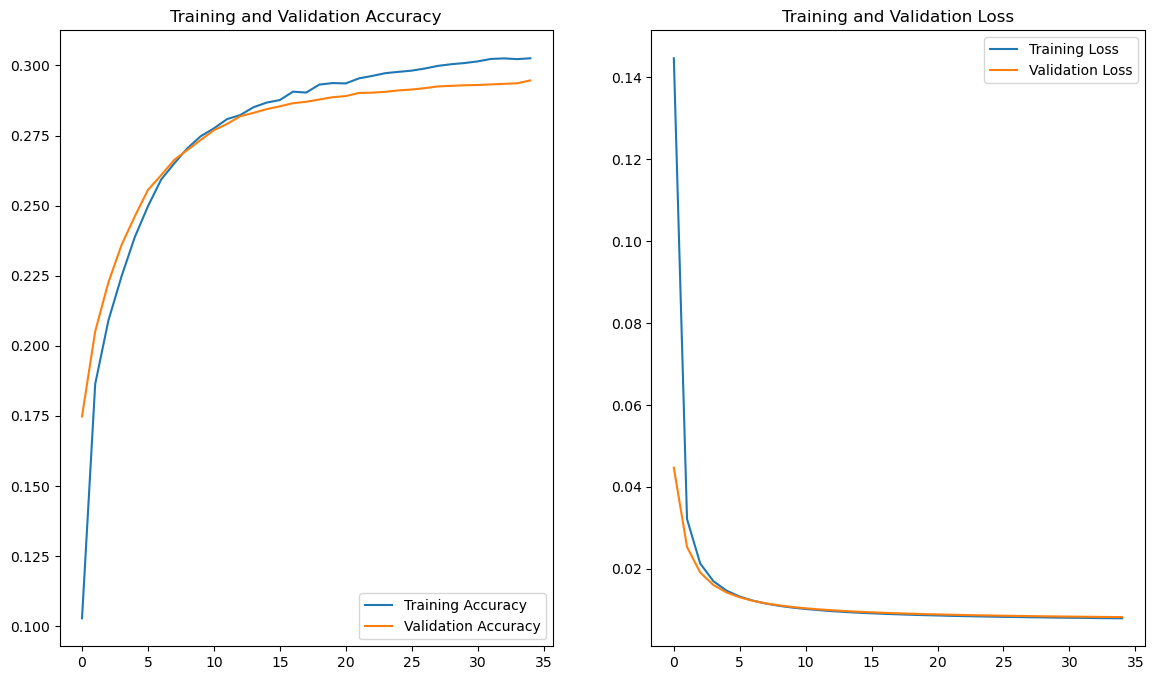

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range =range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [66]:
transfer_model.save('MobileNetV2_Augmented_1944_epoch35.h5')

/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### ResNet50

In [196]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)
for layer in base_model.layers:
    layer.trainable = False

In [197]:
model_new = tf.keras.Sequential([
    base_model,
    layers.Dense(1944, activation='sigmoid')
])
model_new.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_10 (Dense)            (None, 1944)              3983256   
                                                                 
Total params: 27570968 (105.17 MB)
Trainable params: 3983256 (15.19 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [198]:
model_new.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [199]:
history_2 = model_new.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=35,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Epoch 1/35
  1/546 [..............................] - ETA: 16:21 - loss: 1.0282 - accuracy: 0.0000e+00

2024-03-20 14:24:43.431639: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



546/546 [==============================] - 245s 447ms/step - loss: 0.0121 - accuracy: 0.1559 - val_loss: 0.0081 - val_accuracy: 0.1657
Epoch 2/35
546/546 [==============================] - 240s 440ms/step - loss: 0.0078 - accuracy: 0.1898 - val_loss: 0.0080 - val_accuracy: 0.1930
Epoch 3/35
546/546 [==============================] - 240s 439ms/step - loss: 0.0076 - accuracy: 0.2050 - val_loss: 0.0079 - val_accuracy: 0.2036
Epoch 4/35
546/546 [==============================] - 238s 436ms/step - loss: 0.0075 - accuracy: 0.2132 - val_loss: 0.0079 - val_accuracy: 0.2154
Epoch 5/35
546/546 [==============================] - 235s 431ms/step - loss: 0.0074 - accuracy: 0.2186 - val_loss: 0.0079 - val_accuracy: 0.2183
Epoch 6/35
546/546 [==============================] - 230s 421ms/step - loss: 0.0073 - accuracy: 0.2234 - val_loss: 0.0079 - val_accuracy: 0.2260
Epoch 7/35
546/546 [==============================] - 218s 399ms/step - loss: 0.0073 - accuracy: 0.2293 - val_loss: 0.0079 - val_accura

In [200]:
model_new.save('ResNet50_Augmented_1944_epoch-35.h5')

/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### DenseNet121

In [54]:
from tensorflow.keras.applications.densenet import DenseNet121

In [55]:
base_model_dense = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)
for layer in base_model_dense.layers:
    layer.trainable = False

2024-03-20 10:11:06.250512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 10:11:07.725526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 10:11:07.726044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [56]:
densenet_model = tf.keras.Sequential([
    base_model_dense,
    layers.Dense(1944, activation='sigmoid')
])
densenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 1944)              1992600   
                                                                 
Total params: 9030104 (34.45 MB)
Trainable params: 1992600 (7.60 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [116]:
def hamming_loss(y_true,y_pred):
    return tf.reduce_mean(tf.cast(tf.not_equal(y_true,tf.round(y_pred)),tf.int64))

In [57]:
densenet_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [58]:
history_3 = densenet_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=35,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Epoch 1/35


2024-03-20 10:11:26.396572: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 10:11:31.809559: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 10:11:31.813052: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-03-20 10:11:31.813099: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-03-20 10:11:31.813213: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-20 10:11


  1/546 [..............................] - ETA: 3:27:09 - loss: 1.2568 - accuracy: 0.0000e+00

2024-03-20 10:11:43.575223: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

I0000 00:00:1710943903.643848    3013 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-20 10:11:43.701434: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



546/546 [==============================] - 1553s 3s/step - loss: 0.0130 - accuracy: 0.2847 - val_loss: 0.0079 - val_accuracy: 0.3134
Epoch 2/35
546/546 [==============================] - 240s 441ms/step - loss: 0.0071 - accuracy: 0.3195 - val_loss: 0.0074 - val_accuracy: 0.3050
Epoch 3/35
546/546 [==============================] - 239s 438ms/step - loss: 0.0067 - accuracy: 0.3212 - val_loss: 0.0072 - val_accuracy: 0.3116
Epoch 4/35
546/546 [==============================] - 237s 435ms/step - loss: 0.0063 - accuracy: 0.3242 - val_loss: 0.0072 - val_accuracy: 0.3115
Epoch 5/35
546/546 [==============================] - 234s 430ms/step - loss: 0.0061 - accuracy: 0.3251 - val_loss: 0.0073 - val_accuracy: 0.3172
Epoch 6/35
546/546 [==============================] - 229s 420ms/step - loss: 0.0060 - accuracy: 0.3241 - val_loss: 0.0073 - val_accuracy: 0.3133
Epoch 7/35
546/546 [==============================] - 217s 398ms/step - loss: 0.0058 - accuracy: 0.3255 - val_loss: 0.0074 - val_accuracy

In [59]:
densenet_model.save('DenseNet121_epoch35.h5')

/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### ChexNet Weights

In [60]:
base_model_chex = DenseNet121(
    include_top=True,
    weights='brucechou1983_CheXNet_Keras_0.3.0_weights.h5', #pretrained model weights adapted from https://github.com/brucechou1983/CheXNet-Keras
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='max',
    classes = 14
)


ValueError: The `weights` argument should be either `None` (random initialization), `imagenet` (pre-training on ImageNet), or the path to the weights file to be loaded.

In [ ]:
for layer in base_model_chex.layers:
    layer.trainable = False

In [ ]:
chexnet_model = Sequential([
    base_model_chex,
    Dense(1944, activation='sigmoid')
    
])

In [ ]:
chexnet_model.summary()

In [ ]:
chexnet_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history_4 = chexnet_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

In [ ]:
chexnet_model.save('Chexnet_Model.h5')

# SWIN Transform

In [333]:
!pip install transformers

In [122]:
from transformers import AutoImageProcessor, TFSwinForImageClassification

/home/ex5/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [108]:
import sys
sys.path.append('/home/ex5/Desktop/ImageCLEF/2019/Swin-Transformer-TF/swintransformer')
import tensorflow as tf
from model import SwinTransformer

In [123]:
swin_model = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=([224, 224, 3])),
  SwinTransformer('swin_tiny_224', include_top=False, pretrained=True),
  tf.keras.layers.Dense(1944, activation='softmax')
])

In [124]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

swinmodel = TFSwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


2024-03-20 13:41:29.630927: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 13:41:29.630954: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 13:41:29.630976: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 13:41:29.631458: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

2024-03-20 13:41:31.138670: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 13:41:31.138699: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 13:41:31.138732: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-20 13:41:31.138830: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

In [137]:
IMG_SHAPE = (128,IMG_WIDTH, IMG_HEIGHT, 3)
base_model = swinmodel

In [138]:
sample_training_images, _ = next(multilabel_generator_train)

feature_batch = base_model(sample_training_images)
feature_batch.shape

ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFSwinPatchEmbeddings).

Make sure that the channel dimension of the pixel values match with the one set in the configuration.

Call arguments received by layer 'patch_embeddings' (type TFSwinPatchEmbeddings):
  • pixel_values=tf.Tensor(shape=(128, 224, 224, 3), dtype=float32)
  • training=False

In [133]:
print("Number of input channels expected by the model:", swinmodel.config.num_channels)

Number of input channels expected by the model: 3


In [ ]:
inputs = image_processor(multilabel_generator_train, return_tensors="tf")

In [130]:
final_model=tf.keras.Sequential([
    swinmodel,
    tf.keras.layers.Dense(1944, activation='softmax')  # Adjust the output size according to your needs
])

In [131]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [132]:
final_model.fit(multilabel_generator_train, 
                epochs=10, 
                validation_data=multilabel_generator_val)

ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFSwinPatchEmbeddings).

Make sure that the channel dimension of the pixel values match with the one set in the configuration.

Call arguments received by layer 'patch_embeddings' (type TFSwinPatchEmbeddings):
  • pixel_values=tf.Tensor(shape=(128, 224, 224, 3), dtype=float32)
  • training=False

In [134]:
sample_data, _ = next(multilabel_generator_train)
print("Shape of input data:", sample_data.shape)

Shape of input data: (128, 224, 224, 3)


In [329]:
swin_model = SwinTransformer('swin_base_224', num_classes=1000, include_top=True, pretrained=False)



In [114]:
swin_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [115]:
swin_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 swin_tiny_224 (SwinTransfo  (None, 768)               27769058  
 rmerModel)                                                      
                                                                 
 dense_2 (Dense)             (None, 1944)              1494936   
                                                                 
Total params: 29263994 (112.59 MB)
Trainable params: 29014290 (110.68 MB)
Non-trainable params: 249704 (1.91 MB)
_________________________________________________________________


In [116]:
history_5 = swin_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=15,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Epoch 1/15


AssertionError: in user code:

    File "/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file0m9itbmw.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).forward_features, (ag__.ld(x),), None, fscope)
    File "/tmp/__autograph_generated_filei9az354x.py", line 10, in tf__forward_features
        x = ag__.converted_call(ag__.ld(self).patch_embed, (ag__.ld(x),), None, fscope)
    File "/tmp/__autograph_generated_filet0d7msev.py", line 11, in tf__call
        assert ag__.and_(lambda: ag__.ld(H) == ag__.ld(self).img_size[0], lambda: ag__.ld(W) == ag__.ld(self).img_size[1]), f"Input image size ({ag__.ld(H)}*{ag__.ld(W)}) doesn't match model ({ag__.ld(self).img_size[0]}*{ag__.ld(self).img_size[1]})."

    AssertionError: Exception encountered when calling layer 'swin_tiny_224' (type SwinTransformerModel).
    
    in user code:
    
        File "/home/ex5/Desktop/ImageCLEF/2019/Swin-Transformer-TF/swintransformer/model.py", line 422, in call  *
            x = self.forward_features(x)
        File "/home/ex5/Desktop/ImageCLEF/2019/Swin-Transformer-TF/swintransformer/model.py", line 411, in forward_features  *
            x = self.patch_embed(x)
        File "/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filet0d7msev.py", line 11, in tf__call
            assert ag__.and_(lambda: ag__.ld(H) == ag__.ld(self).img_size[0], lambda: ag__.ld(W) == ag__.ld(self).img_size[1]), f"Input image size ({ag__.ld(H)}*{ag__.ld(W)}) doesn't match model ({ag__.ld(self).img_size[0]}*{ag__.ld(self).img_size[1]})."
    
        AssertionError: Exception encountered when calling layer 'patch_embed' (type PatchEmbed).
        
        in user code:
        
            File "/home/ex5/Desktop/ImageCLEF/2019/Swin-Transformer-TF/swintransformer/model.py", line 336, in call  *
                assert H == self.img_size[0] and W == self.img_size[1],             f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
            AssertionError: Input image size (None*None) doesn't match model (224*224).
        
        
        Call arguments received by layer 'patch_embed' (type PatchEmbed):
          • x=tf.Tensor(shape=(None, None, None, 3), dtype=float32)
    
    
    Call arguments received by layer 'swin_tiny_224' (type SwinTransformerModel):
      • x=tf.Tensor(shape=(None, None, None, 3), dtype=float32)


In [60]:
#import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


## Load models

In [60]:
from tensorflow.keras.models import load_model
import keras

In [58]:
 keras.backend.clear_session()

In [87]:
#model_1 = load_model('UMLS Tags Augmented for 5528.h5')
model_2 = load_model('MobileNetV2_Augmented_1944_epoch20.h5')
#model_3 = load_model('ResNet50_Augmented_1944_epoch15.h5')
#model_4 = load_model('UMLS Tags_3.h5')# Trained for 5216 classes
model_5 = load_model('DenseNet121_epoch35.h5')
#model_6 = load_model('Chexnet_Model.h5')

In [70]:
test_dir1 = '/home/ex5/Desktop/ImageCLEF/dataset/test_images'

In [72]:
num_test1 = len(os.listdir(test_dir1))
print(num_test1)

1


In [64]:
test_data_gen1 = test_image_generator.flow_from_dataframe    (
                                                            dataframe=full,
                                                             directory=test_dir1,
                                                            x_col='ID',
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode = None
)
print(batch_size)
print(IMG_HEIGHT, IMG_WIDTH)
print(test_dir)

Found 0 validated image filenames.
128
224 224
/home/ex5/Desktop/ImageCLEF/dataset/images/test


/home/ex5/anaconda3/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 80080 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(


In [71]:
test_image_generator1 = test_image_generator.flow_from_directory(
    test_dir1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,  # Only data, no labels
    shuffle=False  # Do not shuffle the data
)
print(batch_size)
print(IMG_HEIGHT, IMG_WIDTH)
print(test_dir1)

Found 17237 images belonging to 1 classes.
128
224 224
/home/ex5/Desktop/ImageCLEF/dataset/test_images


## Predictions

##### Validation Data

In [84]:
predictions_1 = model_1.predict(val_data_gen)

2024-03-05 15:37:10.271152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


78/78 [==============================] - 35s 453ms/step


In [88]:
predictions_2 = model_2.predict(test_image_generator1)

135/135 [==============================] - 57s 414ms/step


In [73]:
predictions_3 = model_3.predict(test_image_generator1)

2024-04-26 09:49:25.509400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-26 09:49:26.962329: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-04-26 09:49:26.965415: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-04-26 09:49:26.965462: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-04-26 09:49:26.965575: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-04-26 09:49

  1/135 [..............................] - ETA: 23:48

2024-04-26 09:49:34.353300: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-04-26 09:49:34.354292: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


135/135 [==============================] - 69s 433ms/step


In [112]:
predictions_4 = model_4.predict(dev_data_gen)

In [89]:
predictions_5 = model_5.predict(test_image_generator1)

135/135 [==============================] - 58s 416ms/step


In [54]:
predictions_6 = model_6.predict(dev_data_gen)

## Output

#### We used the following procedure for all of the above models

In [94]:
val_predictions = predictions_5

In [91]:
val_predictions.shape

(17237, 1944)

In [82]:
def split_to_semicolons(values):
    items = ''
    for item in values:
        items = item +';' +items
    items = items.rstrip(';')    
    return items  

In [77]:
def to_output_file(val_predictions,threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = []
        for value in temp :
            label.append(mlb.classes_[value])
        labels.append(label)  
    files = pd.DataFrame([])
    files = files._append(os.listdir("/home/ex5/Desktop/ImageCLEF/dataset/images/valid"))
    files.columns = ['image']
    files = files.apply(lambda S:S.str.strip('.jpg'))
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x : split_to_semicolons(x))
    candidate = pd.DataFrame([])
    candidate['pred'] = files.image.map(str) + '\t' + files.CUIs
    return candidate

In [83]:
def to_output_file_test(val_predictions,threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = []
        for value in temp :
            label.append(mlb.classes_[value])
        labels.append(label)  
    files = pd.DataFrame([])
    files = files._append(os.listdir("/home/ex5/Desktop/ImageCLEF/dataset/test_images/test"))
    files.columns = ['image']
    files = files.apply(lambda S:S.str.strip('.jpg'))
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x : split_to_semicolons(x))
    candidate = pd.DataFrame([])
    candidate['pred'] = files.image.map(str) + '\t' + files.CUIs
    return candidate

In [95]:
candidate = to_output_file_test(val_predictions,0.13)

In [96]:
candidate.to_csv("candidate_test_model_5_35epoch.csv",index = False,header = False)

## Results

#### Baseline

In [72]:
df = pd.read_csv("candidate_validation_model_2_35epoch.csv")
#print(df.columns[0])
df_sorted = df.sort_values(by=df.columns[0])
values=df_sorted.iloc[:,0].values
df1 = pd.DataFrame(values, columns=['ID,CUIs'])
df1.to_csv("candidate_validation_model_2_35epoch_sorted.csv",index=False)

# df_sorted=pd.read_csv('candidate_validation_model_5_15epoch_sorted.csv')
# df1=df_sorted.iloc[:,0]+'|'
# df2=df_sorted.iloc[:,1]

# print(df2[])
# df_new.to_csv("candidate_validation_model_5_15epoch_sorted1.csv")
# df_new.head()

# l=[]

# print(df1[0])
# for i in range(10):
#     a=df1[i].split()
#     print(l.append([a[0]+'|'+a[1]]))
    
# print(l)

# y_pred=[]
# for i in range(len(df_sorted)):
#     y_pred.append([])
#     for j in range(1,10):
#         if(not(pd.isnull(df_sorted.iloc[i,j]))):
#             y_pred[i].append(df_sorted.iloc[i,j])
# ypred=[]
               
# for i in range(len(y_pred)):
#     ypred.append(y_pred[i])
    
# print(ypred)

In [73]:
df = pd.read_csv('candidate_validation_model_2_35epoch_sorted.csv')


l=[]

for i in df.iloc[:,0].values:
    a=i.split()
    if(len(a)<2):
        l.append([a[0]+','])
    else:
        b=[a[0]+','+a[1]]
        l.append(b)
    
df1 = pd.DataFrame(l, columns=['ID,CUIs'])

df1.to_csv("candidate_validation_model_2_35epoch_sorted1.csv",index=False)

In [280]:
df = pd.read_csv("candidate_validation_model_5_50epoch.csv")

df_sorted = df.sort_values(by=df.columns[0])
df1=df_sorted.iloc[:,0]

print(df1.head())
yp=[]
for i in df1:
    a=i.split()
    
    if(len(a)<2):
        yp.append('')
    else:
        yp.append(a[1].split(';'))
    
print(yp)
    


9578    ImageCLEFmedical_Caption_2024_valid_000001\tC5...
3705    ImageCLEFmedical_Caption_2024_valid_000002\tC5...
9866    ImageCLEFmedical_Caption_2024_valid_000003\tC5...
211     ImageCLEFmedical_Caption_2024_valid_000004\tC5...
7963    ImageCLEFmedical_Caption_2024_valid_000005\tC5...
Name: ImageCLEFmedical_Caption_2024_valid_008444\tC5441965;C5244027;C5235043;C5231045;C5203670;C4721411;C4551683;C4551650;C4551531;C4545645;C4545644;C4511687;C4476767;C4317009;C4303641;C4302819;C4281599;C4281598;C4281590;C4281589;C4281586;C4274828;C4048328;C4039172;C3888056;C3887615;C3887590;C3887532;C3887513;C3887499;C3854330;C3714787;C3714759;C3714551;C3696979;C3669124;C3665332;C3489393;C3472245;C3266841;C3266688;C3163918;C3163626;C2973725;C2960749;C2960678;C2945625;C2939419;C2937358;C2937240;C2924613;C2924612;C2919452;C2882221;C2733597;C2733397;C2713497;C2712342;C2711599;C2711227;C2711204;C2349948;C2346418;C2336763;C2334731;C2317432;C2239273;C2239176;C2004491;C1962945;C1959589;C1956346;C1956257;C19

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [245]:
df1 = pd.read_csv("valid_concepts.csv")

y_test=[]
for i in range(len(df1)):
     y_test.append(df1.iloc[i,1].split())
        


ytest=[]
for i in y_test:
    ytest.append(i[0].split(';'))
    
print(ytest)


[['C0040405', 'C0856747'], ['C0040405', 'C0040053'], ['C0002978'], ['C0002978', 'C0034052', 'C0521377'], ['C0040405'], ['C0040405', 'C0224417', 'C0018944'], ['C0040405', 'C0025066', 'C0027651'], ['C0040405'], ['C0024485'], ['C0024485'], ['C0041618', 'C0227874'], ['C0040405', 'C0024204', 'C0027540', 'C0013609', 'C0022427'], ['C0040405', 'C0447054', 'C0226032'], ['C0002978', 'C0038257', 'C0226157', 'C0016504', 'C1305387'], ['C1306645', 'C0817096', 'C0002940'], ['C1306645', 'C0037949', 'C1261287'], ['C0040405'], ['C0040405', 'C0032326', 'C5203670'], ['C0002978', 'C0085590'], ['C0040405', 'C0152281', 'C0019080'], ['C0040405', 'C0019080', 'C0039485', 'C0016733', 'C0013604', 'C0013609'], ['C0040405', 'C0267771', 'C0027651', 'C0023884'], ['C1306645', 'C0023216'], ['C0040405', 'C0031039'], ['C0024485', 'C0039485', 'C0444611'], ['C0024485', 'C0039485'], ['C0041618', 'C0225860', 'C0003956', 'C1269894', 'C0225897', 'C0225883'], ['C0040405', 'C0034606', 'C0497156', 'C1699633'], ['C0032743'], ['C13

In [247]:
from sklearn.metrics import f1_score
import numpy as np


f1_scores = []
for pred, true_labels in zip(yp, ytest):
    pred_set = set(pred)
    true_set = set(true_labels)
    # Calculate precision, recall, and F1-score
    if len(pred_set)>0 and len(true_set)>0:
        precision = len(pred_set.intersection(true_set)) / len(pred_set)
        recall = len(pred_set.intersection(true_set)) / len(true_set)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
        print(f1)

# Average F1-score across all indices
avg_f1_score = np.mean(f1_scores)
print("Average F1-score:", avg_f1_score)

0
0
0
0.4
0.33333333333333337
0
0
0.6666666666666666
1.0
0
0
0
0.4
0
0
0
0
0
0
0.2
0
0
0.25
0.5
0
0
0
0
0
0.3333333333333333
0
0.1818181818181818
0.4
0
0
0
0
0.3333333333333333
0
0.28571428571428575
0.5
0
0
0
0
0
0
0.28571428571428575
0
0.6666666666666666
0
0
0
0
0
0
0
0.5
0
0
0
0
0
0
0
0
0.25
0
0
0
0.2222222222222222
0.3333333333333333
0
0
0.2222222222222222
0
0
0
0
0.18181818181818182
0
0
0.2
0
0
0
0
0
0.4
0.3333333333333333
0
0.25
0
0
0.18181818181818182
0.28571428571428575
0
0.2
0
0
0.22222222222222224
0
0.4
0
0
0
0
0
0
0.4
0
0.6666666666666666
0
0
0
0
0
0
0
0.09523809523809523
0
0
0.18181818181818182
0
0
0
0.2
0
1.0
0.33333333333333337
0.22222222222222224
0.2222222222222222
0
0
0
0
0
0
0.4
0
0.6666666666666666
0
0
0
0
0
0
0
0.4
0.5
0.16666666666666666
0
0
0
0
0.1818181818181818
0
0.6666666666666666
0.2
0.25
0
0
0
0
0
0.4
0.3333333333333333
0
0.3333333333333333
0
0
0
0
0
0
0
0.6666666666666666
0
0.3333333333333333
0
0
0.25
0.5714285714285715
0
0
0
0.16666666666666666
0
0
0
0.4
0
0.

In [71]:
%run evaluate-f1.py candidate_validation_dummy_model.csv ground_truth_val.csv

FileNotFoundError: [Errno 2] No such file or directory: 'candidate_validation_dummy_model.csv'

<Figure size 640x480 with 0 Axes>

#### Rest of Models

In [6]:
%run evaluator.py

loading ground truth...
evaluate...
load predictions...
compute primary score...
compute secondary score...
{'score': 1.0, 'score_secondary': 0.0}


In [272]:
%run evaluate-f1.py candidate_validation_model_2.csv ground_truth_val.csv 

FileNotFoundError: [Errno 2] No such file or directory: 'ground_truth_val.csv'

In [73]:
%run evaluate-f1.py candidate_validation_model_3.csv ground_truth_val.csv

FileNotFoundError: [Errno 2] No such file or directory: 'ground_truth_val.csv'

In [117]:
%run evaluate-f1.py candidate_validation_model_4.csv ground_truth_val.csv

Input parameters
********************************
Candidate file is "candidate_validation_model_4.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [77]:
%run evaluate-f1.py candidate_validation_model_5.csv ground_truth_val.csv

Input parameters
********************************
Candidate file is "candidate_validation_model_5.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [91]:
%run evaluate-f1.py candidate_validation_model_6.csv ground_truth_val.csv #tuned for results greater than 0.21

Input parameters
********************************
Candidate file is "candidate_validation_model_6.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

#### Notes
* To create the ground truth file we used te same procedure as the candidate file using the dataframe val_concepts


* All validation predictions threshold were tuned based on the occuring f1 score


* The best f1 score we managed to achieve on the validation data was $0.1589$ using the DenseNet121 pre trained model


* Thus, this model is the one we will use for the creation of the predictions on the test set

In [78]:
test_pred = model_5.predict(test_image_gen1)

In [80]:
labels = []
for i in range(val_predictions.shape[0]):
    temp = np.where(val_predictions[i] > 0.13)[0]
    label = []
    for value in temp :
        label.append(mlb.classes_[value])
    labels.append(label) 
    
files = pd.DataFrame([])
files = files.append(os.listdir("data/test_set/test"))
files.columns = ['image']
files = files.apply(lambda S:S.str.strip('.jpg'))
files['cui'] = labels
files['cui'] = files['cui'].apply(lambda x : split_to_semicolons(x))
cand = pd.DataFrame([])
cand['pred'] = files.image.map(str) + '\t' + files.cui

AttributeError: 'DataFrame' object has no attribute 'append'

In [85]:
cand.to_csv("candidate_test_model_3.csv",index = False,header = False)